In [38]:
import torch
import torchvision
import numpy as np
from PIL import Image
import json
import numpy as np 
import math
import matplotlib.pyplot as plt 
import os

json_path = './annotations/mpii/fullannotations.json'
joint_path = './annotations/mpii/jointdict.json'
histogram_path = './annotations/mpii/histogram.json'
images_path = './images/mpii_resized'
mapp_path = './images/mpii_map'

with open(json_path, 'r') as fp:
    json_list = json.load(fp)

with open(joint_path, 'r') as fp:
    joint_dict = json.load(fp)

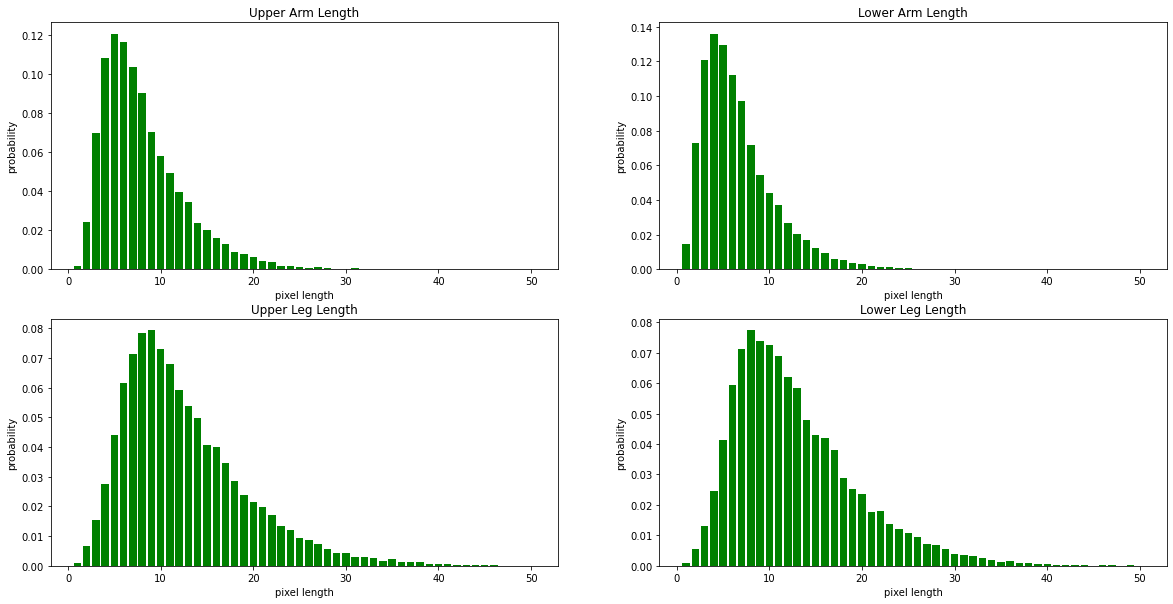

In [39]:
def visualize_histogram(histogram_path, end = 50, grid = (2, 2)):
    
    def plot(i, histogram, title, color, norm=True):
        histogram = np.array(histogram)
        if norm:
            histogram = histogram / np.sum(histogram)
        
        plt.subplot(*grid, i)
        plt.bar(range(1, end+1), histogram, color=color)
        plt.title(title)
        plt.ylabel('probability')
        plt.xlabel('pixel length')
    
    with open(histogram_path, 'r') as fp:
        joint_histogram = json.load(fp)

    plt.figure(figsize=(20, 10))
    
    plot(1, joint_histogram['u_arm'][:end], 'Upper Arm Length', 'g')
    plot(2, joint_histogram['l_arm'][:end], 'Lower Arm Length', 'g')
    plot(3, joint_histogram['u_leg'][:end], 'Upper Leg Length', 'g')
    plot(4, joint_histogram['l_leg'][:end], 'Lower Leg Length', 'g')
    plt.show()

visualize_histogram(histogram_path)

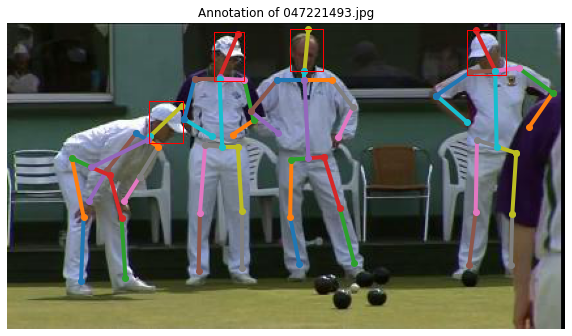

In [104]:
def get_joint(joint_id, joint_list):
    for joint in joint_list:
        if joint['id'] == joint_id: return joint
    return None

def plot_line(coor1, coor2, marker='o', linewidth=4, color=None):
    if coor1 and coor2: 
        x1, y1 = coor1
        x2, y2 = coor2
        plt.plot([x1, x2], [y1, y2], marker=marker, linewidth=linewidth, color=color)
        
def plot_rect(x1, y1, x2, y2):
    plot_line((x1, y1), (x1, y2), '', 1, 'r')
    plot_line((x1, y2), (x2, y2), '', 1, 'r')
    plot_line((x2, y2), (x2, y1), '', 1, 'r')
    plot_line((x2, y1), (x1, y1), '', 1, 'r')

def present_pose(image_array, people_list, joint_dict, title):
    plt.figure(figsize=(10, 20))
    plt.axis('off')
    plt.imshow(image_array)
    plt.title(title)

    for person in people_list:
        joint_list = person['joints']
        joint_map = {}
        for k in joint_dict:
            joint_temp = get_joint(joint_dict[k], joint_list)
            if not joint_temp: 
                joint_map[k] = None
            else:
                joint_map[k] = (joint_temp['x'], joint_temp['y'])

        # legs
        plot_line(joint_map['r_ankle'], joint_map['r_knee'])
        plot_line(joint_map['r_knee'], joint_map['r_hip'])
        plot_line(joint_map['l_ankle'], joint_map['l_knee'])
        plot_line(joint_map['l_knee'], joint_map['l_hip'])
        # arms
        plot_line(joint_map['r_wrist'], joint_map['r_elbow'])
        plot_line(joint_map['r_elbow'], joint_map['r_shoulder'])
        plot_line(joint_map['l_wrist'], joint_map['l_elbow'])
        plot_line(joint_map['l_elbow'], joint_map['l_shoulder'])
        # head
        plot_line(joint_map['upper_neck'], joint_map['head_top'])
        plot_line(joint_map['upper_neck'], joint_map['thorax'])
        # body
        plot_line(joint_map['r_shoulder'], joint_map['thorax'])
        plot_line(joint_map['l_shoulder'], joint_map['thorax'])
        plot_line(joint_map['r_hip'], joint_map['pelvis'])
        plot_line(joint_map['l_hip'], joint_map['pelvis'])
        plot_line(joint_map['thorax'], joint_map['pelvis'])
        
#         if not 'head_coordinates' in person: continue
        person_head = person['head_coordinates']
        x1 = person_head['x1']
        y1 = person_head['y1']
        x2 = person_head['x2']
        y2 = person_head['y2']
        
        plot_rect(x1, y1, x2, y2) # draw head
    
    plt.show()
    
def show_image(image_object, images_path):
    image_name = image_object['image_name']
    image_array = np.array(Image.open(os.path.join(images_path, image_name)))
    
    present_pose(image_array, image_object['people'], joint_dict, f'Annotation of {image_name}')

#     print(json.dumps(image_object, indent=1))

show_image(json_list[24], images_path)

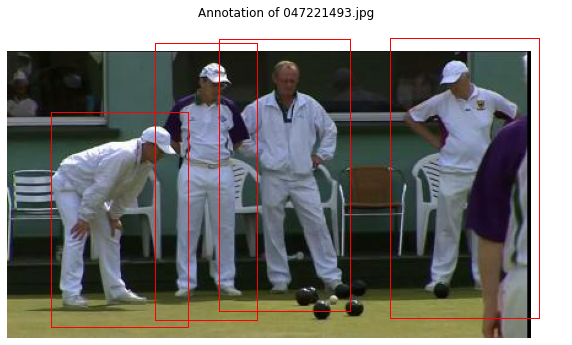

In [103]:
def find(joint_list, lambda_fn):
    _ss = joint_list[0]
    for e in joint_list:
        if not lambda_fn(e, _ss): continue
        _ss = e
    return _ss

def head_width(head_c):
    width = abs(head_c['x1'] - head_c['x2']) 
    height = abs(head_c['y1'] - head_c['y2'])
    return (width + height) // 4

def draw_person_rect(joint_list, head_coor):
    c = head_width(head_coor)
    
    minx = find(joint_list, lambda c, e: c['x'] < e['x'])['x']
    maxx = find(joint_list, lambda c, e: c['x'] > e['x'])['x']
    miny = find(joint_list, lambda c, e: c['y'] < e['y'])['y']
    maxy = find(joint_list, lambda c, e: c['y'] > e['y'])['y']
    
#     print(minx, miny, maxx, maxy)
    
    plot_rect(minx - c, miny - c, maxx + c, maxy +  2 * c)
            
        
def present_body_parts(image_array, people_list, joint_dict, title, draw_head=True, draw_bbox=False, draw_pose=True):
    plt.figure(figsize=(10, 20))
    plt.axis('off')
    plt.imshow(image_array)
    plt.title(title)

    for person in people_list:
        joint_list = person['joints']
        joint_map = {}
        for k in joint_dict:
            joint_temp = get_joint(joint_dict[k], joint_list)
            if not joint_temp: 
                joint_map[k] = None
            else:
                joint_map[k] = (joint_temp['x'], joint_temp['y'])
        if draw_pose:
            # legs
            plot_line(joint_map['r_ankle'], joint_map['r_knee'])
            plot_line(joint_map['r_knee'], joint_map['r_hip'])
            plot_line(joint_map['l_ankle'], joint_map['l_knee'])
            plot_line(joint_map['l_knee'], joint_map['l_hip'])
            # arms
            plot_line(joint_map['r_wrist'], joint_map['r_elbow'])
            plot_line(joint_map['r_elbow'], joint_map['r_shoulder'])
            plot_line(joint_map['l_wrist'], joint_map['l_elbow'])
            plot_line(joint_map['l_elbow'], joint_map['l_shoulder'])
            # head
            plot_line(joint_map['upper_neck'], joint_map['head_top'])
            plot_line(joint_map['upper_neck'], joint_map['thorax'])
            # body
            plot_line(joint_map['r_shoulder'], joint_map['thorax'])
            plot_line(joint_map['l_shoulder'], joint_map['thorax'])
            plot_line(joint_map['r_hip'], joint_map['pelvis'])
            plot_line(joint_map['l_hip'], joint_map['pelvis'])
            plot_line(joint_map['thorax'], joint_map['pelvis'])
        
#         if not 'head_coordinates' in person: continue
            
        person_head = person['head_coordinates']
        x1 = person_head['x1']
        y1 = person_head['y1']
        x2 = person_head['x2']
        y2 = person_head['y2']
        
        if draw_head:
            plot_rect(x1, y1, x2, y2) # draw head
        
        if draw_bbox:
            draw_person_rect(joint_list, person_head) # draw body
    
    plt.show()
    
def show_image(image_object, images_path):
    image_name = image_object['image_name']
    image_array = np.array(Image.open(os.path.join(images_path, image_name)))
    
    present_body_parts(image_array, image_object['people'], joint_dict, f'Annotation of {image_name}',\
                      draw_head=False, draw_bbox=True, draw_pose=False)

#     print(json.dumps(image_object, indent=1))

show_image(json_list[24], images_path)